In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import numpy as np

%matplotlib inline  

In [2]:
references = pd.read_csv('data/References.csv', index_col=0)

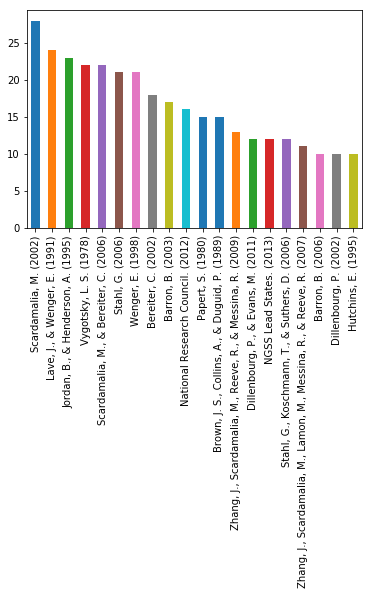

In [3]:
references.ref_parsed.value_counts().head(20).plot(kind='bar')

# get document identifier

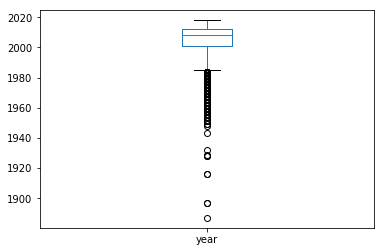

In [4]:
references.year.plot(kind='box')

In [5]:
references.head()

,ref,file,ref_parsed,year,identifier
0,"Abrahamson, D. (2012). Discovery reconceived: ...",import2016full/61,"Abrahamson, D. (2012)",2012.0,"Abrahamson, D. (2012). Discovery reconceived: ..."
1,"Abrahamson, D. (2015). The monster in the mach...",import2016full/61,"Abrahamson, D. (2015)",2015.0,"Abrahamson, D. (2015). The monster in the mach..."
2,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ...",import2016full/61,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ...",2014.0,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ..."
3,"Abrahamson, D., & Sánchez-García, R. (in press...",import2016full/61,"Abrahamson, D., & Sánchez-García, R. (in press",NaN,"Abrahamson, D., & Sánchez-García, R. (in press)"
4,"Abrahamson, D., Shayan, S., Bakker, A., & Van ...",import2016full/61,"Abrahamson, D., Shayan, S., Bakker, A., & Van ...",NaN,"Abrahamson, D., Shayan, S., Bakker, A., & Van ..."


In [6]:
sample = references[['ref', 'identifier']].sample(4)
sample.ref.tolist()

['Roschelle, J., Penuel, W. R., & Shechtman, N. (2006). Co-design of Innovations with Teachers: Definition and Dynamics. In Proceedings of the 7th International Conference on Learning Sciences (pp. 606–612). Bloomington, Indiana: International Society of the Learning Sciences.',
 "Heath, C., & vom Lehn, D. (2008). Configuring 'Interactivity' Enhancing Engagement in Science Centres and Museums. Social Studies of Science,38(1), 63-91.",
 'diSessa, A. A., & Sherin, B. L. (2000). Meta-representation: An introduction. The Journal of Mathematical Behavior, 19(4), 385-398. doi:http://dx.doi.org/10.1016/S0732-3123(01)00051-7',
 'Sharma, K., Caballero, D., Verma, H., Jermann, P., & Dillenbourg, P. (2015). Looking AT versus Looking THROUGH: A Dual Eye-Tracking Study in MOOC Context. In Procs. of 11th International Conference of Computer Supported Collaborative Learning, Gothenburg, Sweden, CSCL.']

In [7]:
sample.identifier.tolist()

['Roschelle, J., Penuel, W. R., & Shechtman, N. (2006). Co-design of Innovations with Teachers: Definition and Dynamics',
 "Heath, C., & vom Lehn, D. (2008). Configuring 'Interactivity' Enhancing Engagement in Science Centres and Museums",
 'diSessa, A. A., & Sherin, B. L. (2000). Meta-representation: An introduction',
 'Sharma, K., Caballero, D., Verma, H., Jermann, P., & Dillenbourg, P. (2015). Looking AT versus Looking THROUGH: A Dual Eye-Tracking Study in MOOC Context']

# Merge names with references:

In [8]:
metadata = pd.read_csv('data/Parsed_metadata.csv')

In [9]:
reference_authors = pd.read_csv('data/Reference_authors.csv', index_col=0)
reference_authors.shape

(20251, 2)

In [10]:
reference_authors.drop_duplicates(inplace=True)
reference_authors.shape

(17231, 2)

In [11]:
reference_authors.head()

,author,file
0,Abrahamson D.,import2016full/61
3,Lee R. G.,import2016full/61
4,Negrete A. G.,import2016full/61
5,Gutiérrez J. F.,import2016full/61
7,Sánchez-García R.,import2016full/61


In [12]:
reference_edges = pd.merge(metadata, reference_authors, on='file')[['shortend_names', 'author']]

In [13]:
reference_edges.columns = ['author', 'cited']

People who like to cite themselves:

In [14]:
reference_edges[reference_edges.author == reference_edges.cited].author.value_counts().head()

Zhang J.          11
Dillenbourg P.    11
Rummel N.         10
Puntambekar S.    10
Slotta J. D.       9
Name: author, dtype: int64

In [15]:
set(reference_edges.author.tolist()) in set(reference_edges.cited.tolist())

False

In [16]:
print('Number of distinct authors ', len(reference_edges.author.unique()))
print('Number of distinct cited authors by some author in the conference ', len(reference_edges.cited.unique()))
print('Number of authors that where cited by an other author in the confernce :' , len(set(reference_edges.cited.tolist()).intersection(set(reference_edges.author.tolist()))))

Number of distinct authors  1010
Number of distinct cited authors by some author in the conference  8035
Number of authors that where cited by an other author in the confernce : 561


In [17]:
not_in_conference = list(set(reference_edges.cited) - set(reference_edges.author))

In [18]:
reference_edges['participated'] = reference_edges.cited.map(lambda x : 0 if x in not_in_conference else 1)

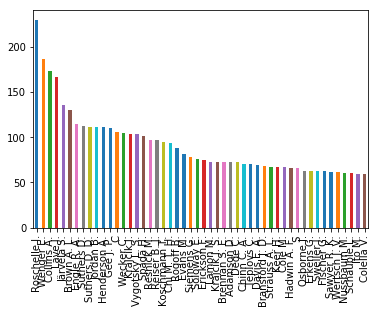

In [19]:
reference_edges[reference_edges.participated == 0].cited.value_counts().head(50).plot(kind = 'bar')

## References

In [20]:
references = pd.read_csv('data/References.csv', index_col=0)

In [21]:
references.ref.sample(5).tolist()

['Kolowich, S. (2013, May 1). Faculty backlash grows against online partners. Chronicle of Higher Education.',
 'Sampson, V., & Clark, D. B. (2008). Assessment of the ways students generate arguments in science education: Current perspectives and recommendations for future directions. Science Education, 92(3), 447-472.',
 'Zhang, J., Lee, J., & Wilde, J. (2012). Metadiscourse to foster collective responsibility for deepening inquiry. In J. van Aalst, K. Thompson, M. J. Jacobson, & P. Reimann (Eds.), Proceedings of the International Conference of the Learning Sciences (pp. 395-402). International Society of the Learning Sciences.',
 'Puntambekar, S. (2013). Mixed methods for analyzing collaborative learning. In C. E. Hmelo-Silver, C. A. Chinn, C. Chan, & A. M. O’Donnell (Eds.), The International Handbook of Collaborative Learning (pp. 220-232). New York, NY: Routledge.',
 'Schön, D. A. (1983). The Reflective Practitioner. Basic Books.']

# Building the refrence graph:

directed graph weighted by number of times x cited y:

In [22]:
nodes = pd.DataFrame(reference_edges.author.drop_duplicates().reset_index(drop=True)).reset_index()

In [23]:
nodes.head()

,index,author
0,0,Shayan S.
1,1,Bakker A.
2,2,Abrahamson D.
3,3,Schaaf M. F.
4,4,Saleh A.


In [24]:
edges = pd.merge(nodes, reference_edges, left_on='author', right_on='cited')
del edges['author_x'], edges['participated']

In [25]:
edges = pd.merge(nodes, edges, left_on='author', right_on='author_y')
del edges['author_y'], edges['author'], edges['cited']

In [26]:
edges.columns = ['author', 'citation']
edges

,author,citation
0,0,0
1,0,1
2,0,2
3,0,3
4,0,21
5,0,249
6,0,278
7,0,298
8,0,397
9,0,994


In [27]:
n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in edges.iterrows():
    if np.isnan(row.author):
        continue
    i, j = int(row.author), int(row.citation)
    adjacency[j, i] += 1

In [28]:
adjacency.shape

(1010, 1010)

In [29]:
degrees = np.where(adjacency > 0, 1, 0).sum(axis=0)

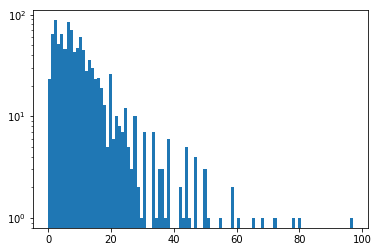

In [30]:
plt.hist(degrees, bins=100, log=True)
plt.show()

In [31]:
import networkx as nx

graph = nx.from_numpy_array(adjacency)

mapping = nodes.author.to_dict()

H=nx.relabel_nodes(graph,mapping)
print(sorted(H.nodes()))

nx.write_gexf(H, 'data/refrence_graph.gexf')

['Aalst J.', 'Abdu R.', 'Abrahamson D.', 'Acosta A.', 'Adanır G. A.', 'Aditomo A.', 'Adleberg B.', 'Agrawal H.', 'Ahn J.', 'Ahonen A. K.', 'Ainsworth S.', 'AlQahtani M.', 'Alameh S.', 'Albrecht J.', 'Aleven V.', 'Allen C. D.', 'Allen L.', 'Allert H.', 'Almatrafi O.', 'Alqassab M.', 'Alstyne R.', 'Amzalag M.', 'Anderson C. G.', 'Anderson E.', 'Anderson J.', 'Anderson R. C.', 'Andrade A.', 'Andrews J. J.', 'Angelo S.', 'Angersbach J.', 'Anjewierden A.', 'Antle A. N.', 'Apollonia S.', 'Applebaum L.', 'Applebaum L. R.', 'Arastoopour G.', 'Arnedillo-Sanchez I.', 'Arnseth H. C.', 'Arvaja M.', 'Arvidsson T. S.', 'Ashley R. W.', 'Askari E.', 'Asterhan C.', 'Awwal N.', 'Ayer T.', 'Azevedo F. S.', 'Azevedo R.', 'Baker R.', 'Bakker A.', 'Bal A.', 'Baltes J.', 'Bang M.', 'Bannan B.', 'Baram-Tsabari A.', 'Barber-Lester K.', 'Barber-Lester K. J.', 'Barcellos M. E.', 'Barrat A.', 'Barron B.', 'Barth-Cohen L. A.', 'Barton A. C.', 'Baruch A. F.', 'Barzilai S.', 'Basu S.', 'Beck S.', 'Becker S.', 'Bell 